Import required Packages

In [1]:
%config IPCompleter.greedy=True
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os.path
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import KBinsDiscretizer
from sklearn import preprocessing

import category_encoders as ce


URL of the datasets and storing datasets in dataframes

In [2]:
url_for_traindata =  os.path.join(os.path.realpath('.'),'tcd ml 2019-20 income prediction training (with labels).csv')
url_for_testdata = os.path.join(os.path.realpath('.'),'tcd ml 2019-20 income prediction test (without labels).csv')
output_url = os.path.join(os.path.realpath('.'),'tcd ml 2019-20 income prediction submission file.csv')
temp_output = os.path.join(os.path.realpath('.'),'output.csv')

training_dataframe = pd.read_csv(url_for_traindata)
test_dataframe = pd.read_csv(url_for_testdata)

Comparing the income for each features.(Removed peice of code for other features) 

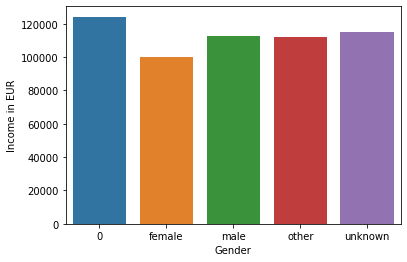

In [3]:
incomePerc = training_dataframe[["Gender", "Income in EUR"]].groupby(['Gender'],as_index=False).mean()
sns.barplot(x='Gender', y='Income in EUR', data=incomePerc)
# sns.regplot(x='Year of Record', y='Income in EUR', data=training_dataframe)
# plt.ylim(0,)

Count missing values in each column and dropping rows with both gender and profession is null 

In [4]:
print(training_dataframe.isnull().sum())
index_to_drop = training_dataframe[((training_dataframe.Gender == 'unknown') | (pd.isnull(training_dataframe.Gender))) & ((pd.isnull(training_dataframe.Profession)))].index
training_dataframe.drop(index_to_drop,inplace= True)
print(training_dataframe.shape)

Instance                0
Year of Record        441
Gender               7432
Age                   494
Country                 0
Size of City            0
Profession            322
University Degree    7370
Wears Glasses           0
Hair Color           7242
Body Height [cm]        0
Income in EUR           0
dtype: int64
(111940, 12)


Combining both test and train data together so that data cleaning and preprocessing can be done after droping income column from both test and train data.

In [5]:
y = training_dataframe['Income in EUR']
train_model = training_dataframe.drop(columns =['Income in EUR'])
test_model =  test_dataframe.drop(columns =['Income'])                                                     
combined_df = pd.concat([train_model, test_model])
print(combined_df.isnull().sum())
print(train_model.shape)
print(test_model.shape)
print(combined_df.shape)
# combined_df.head
# combined_df.groupby(combined_df.Age).count()()
#pd.DataFrame({'labels':combined_df.Profession.unique()[:]}).labels.sort_values().to_csv(temp_output)

Instance                 0
Year of Record         736
Gender               12274
Age                    773
Country                  0
Size of City             0
Profession             464
University Degree    12223
Wears Glasses            0
Hair Color           12157
Body Height [cm]         0
dtype: int64
(111940, 11)
(73230, 11)
(185170, 11)


<h3>Data pre-processing</h3>

   * Using SimpleImputer to replcae nan with unknown for all series of type object and with mean for all series      of type number.     (ravel() is applied to avoid error of numpy array dimension)
    * replacing 0 in gender as male
    * replacing 0 in university dergree as Bachelor.
    * replacing  country names with less than 100 count as 'notimportant'
    * replacing  age > 100 with mean of age > 100 in the dataset

In [6]:
imp_gender = SimpleImputer(missing_values=np.nan, strategy='constant',fill_value='unknown')
# imp_university = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imp_university = SimpleImputer(missing_values=np.nan, strategy='constant',fill_value='unknown')
imp_profession = SimpleImputer(missing_values=np.nan, strategy='constant',fill_value='unknown')

mp_profession = imp_profession.fit(combined_df[['Profession']])
combined_df['Profession'] = imp_profession.transform(combined_df[['Profession']]).ravel()

imp_gender = imp_gender.fit(combined_df[['Gender']])
combined_df['Gender'] = imp_gender.transform(combined_df[['Gender']]).ravel()

imp_university = imp_university.fit(combined_df[['University Degree']])
combined_df['University Degree'] = imp_university.transform(combined_df[['University Degree']]).ravel()

combined_df['Gender'].replace('0','male',inplace = True)
combined_df['University Degree'].replace('0','Bachelor',inplace = True)

avg_year = combined_df["Year of Record"].astype("float").mean(axis=0)
avg_age = combined_df["Age"].astype("float").mean(axis=0)

combined_df["Year of Record"].replace(np.nan, avg_year, inplace=True)
combined_df["Age"].replace(np.nan, avg_age, inplace=True)

countries_count_greaterthan100 = combined_df.Country.value_counts()[combined_df.Country.value_counts() > 100]
countrylist = countries_count_greaterthan100.index.tolist()
combined_df.Country.where(combined_df.Country.isin(countrylist),'notimportant',inplace = True)
combined_df.Age.where(combined_df.Age <= 100,109.33,inplace = True)
#decide what to do for unkown gender

Tried age binning but no improvement found.
* Min max noramalization on year of record and age

In [7]:
# age_bin = np.linspace(min(combined_df["Age"]),max(combined_df["Age"]),4)
# age_group = ["age0","age1","age2"]
# combined_df["Age_Binned"] = pd.cut(combined_df['Age'], bins=age_bin, labels=age_group)

# f, axes = plt.subplots(1, 2,figsize=(15,5))
# p1=sns.countplot(combined_df['Age_Binned'],ax=axes[0])
# for p in p1.patches:
#     height = p.get_height()
#     p1.text(p.get_x()+p.get_width()/2,height + 50,height,ha="center")       
# axes[0].set(xlabel='Age')
# axes[0].yaxis.tick_left()


scaler = MinMaxScaler()
scaler =scaler.fit(combined_df[['Year of Record']])
combined_df['Year of Record'] = scaler.transform(combined_df[['Year of Record']]).ravel()
scaler =scaler.fit(combined_df[['Age']])
combined_df['Age'] = scaler.transform(combined_df[['Age']]).ravel()
combined_df.head()

,Instance,Year of Record,Gender,Age,Country,Size of City,Profession,University Degree,Wears Glasses,Hair Color,Body Height [cm]
0,1,0.435897,male,0.283227,Belarus,1239930,steel workers,Bachelor,0,Blond,193
1,2,0.410256,other,0.283227,Singapore,1603504,safe event coordinator,Master,0,Black,186
2,3,0.974359,other,0.146858,Norway,1298017,receivables/payables analyst,PhD,1,Brown,170
3,4,0.666667,other,0.199308,Cuba,751903,fleet assistant,No,1,Black,171
4,5,0.769231,female,0.335676,United Arab Emirates,95389,lead trainer,Bachelor,0,Blond,188


* one-hot encoding on 'Gender','Country','University Degree' using get_dummies
* Label encoding on profession also tried HashEncoder
* Dropped columns that seemed to have no effect based on correlation and trial and error


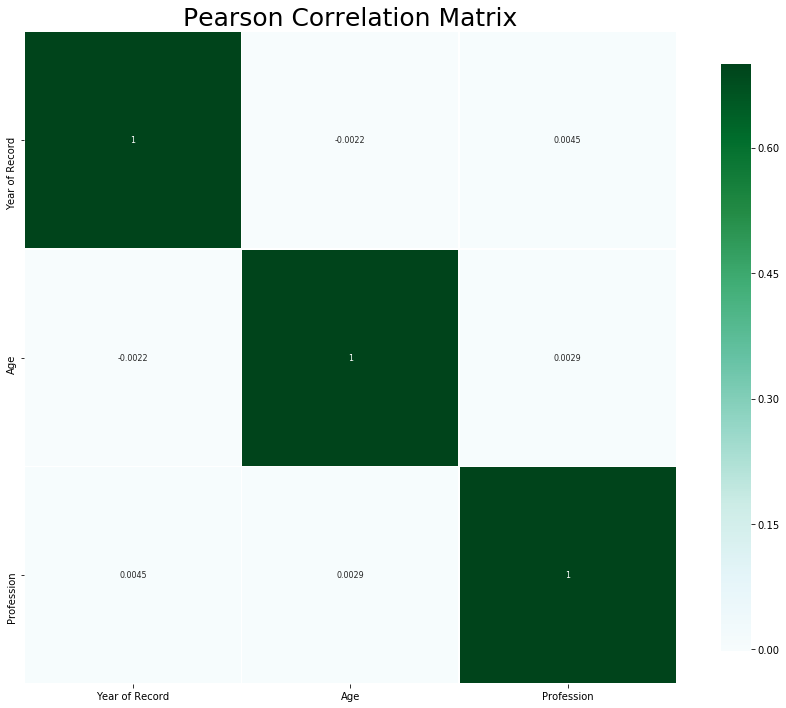

In [8]:
combined_df.drop(columns =['Instance','Size of City','Wears Glasses','Hair Color','Body Height [cm]'],inplace= True)

le = preprocessing.LabelEncoder()
combined_df.Profession = le.fit_transform(combined_df.Profession)

f, ax = plt.subplots(figsize=(16, 12))
plt.title('Pearson Correlation Matrix',fontsize=25)
sns.heatmap(combined_df.corr(),linewidths=0.25,vmax=0.7,square=True,cmap="BuGn",linecolor='w',annot=True,annot_kws={"size":8},cbar_kws={"shrink": .9});
# encoder = ce.HashEncoder(cols=['Profession'])
# combined_df_onehot_encoded = encoder.fit_transform(combined_df_onehot_encoded)

# combined_df_onehot_encoded.Profession = combined_df_onehot_encoded.Profession.ffill()
combined_df_onehot_encoded = pd.get_dummies(combined_df, columns =['Gender','Country','University Degree'])

Splitting back test and train data model after preprocessing

In [9]:
train_X = combined_df_onehot_encoded.iloc[0:111940, :]
test_X  = combined_df_onehot_encoded.iloc[111940:, :]
print(train_X.shape)
print(test_X.shape)
print(combined_df_onehot_encoded.shape)


(111940, 120)
(73230, 120)
(185170, 120)


Randomo forest algorithm implemtation using  Scikit RandomForestRegressor also tried Linear Regression

In [10]:
# train_X, val_X, train_y, val_y = train_test_split(X, y,test_size = 0.3, random_state = 0)
# current_model = linear_model.LinearRegression()
# current_model.fit(train_X,y)
# val_predictions = current_model.predict(train_X)
# rmsecm2 = float(format(np.sqrt(metrics.mean_squared_error(y, val_predictions)),'.3f'))

reg = RandomForestRegressor(n_estimators=10, random_state=125, min_samples_split=2, n_jobs=-1)
reg.fit(train_X,y)
pred = reg.predict(train_X)
prediction = reg.predict(test_X)
rmsecm = float(format(np.sqrt(metrics.mean_squared_error(y, pred)),'.3f'))
print(rmsecm)


29102.326


Writing the final output to csv file

In [11]:
result = pd.DataFrame({'Instance':test_dataframe.Instance,'Income':prediction})
result.to_csv(output_url)